In [1]:
import torch
import torch.nn as nn
import gym

from seagul.nn import Categorical_MLP, MLP, DummyNet, fit_model, LinearNet

# TODO maybe import algos into rl __init__
from seagul.rl.ppo_switching import ppo_switch
from seagul.rl.ppo import ppo

from tqdm import trange
from numpy import pi
import numpy as np

import matplotlib.pyplot as plt

torch.set_default_dtype(torch.double)

policy = MLP(input_size=4, output_size=1, layer_size=24, num_layers=3, activation=nn.ReLU)
value_fn = MLP(input_size=4, output_size=1, layer_size=24, num_layers=3, activation=nn.ReLU)

#policy = LinearNet(17,6)
#value_fn = LinearNet(17,1)
gate_fn = Categorical_MLP(input_size=4, output_size=1, layer_size=12, num_layers=2, activation=nn.ReLU)

/Users/sgillen/.local/lib/python3.6/site-packages/gym/envs/registration.py:64: UserWarning: register(timestep_limit=1000) is deprecated. Use register(max_episode_steps=1000) instead.
  warnings.warn("register(timestep_limit={}) is deprecated. Use register(max_episode_steps={}) instead.".format(timestep_limit, timestep_limit))


In [2]:
# Generate data for the supervised learning task
env = gym.make('su_cartpole-v0')
num_points = int(2e4)

X = torch.zeros(num_points, env.observation_space.shape[0])  
Y = torch.zeros(num_points,1)

for i in trange(num_points):
        
        point = env.observation_space.sample()
        X[i] = torch.as_tensor(point)
        
        if (point[0] > 145 * pi / 180) and (point[0] < 215 * pi / 180):
            Y[i] = 1
        else:
            Y[i] = 0
            

100%|██████████| 20000/20000 [00:01<00:00, 11641.40it/s]


100%|██████████| 50/50 [00:26<00:00,  1.89it/s]


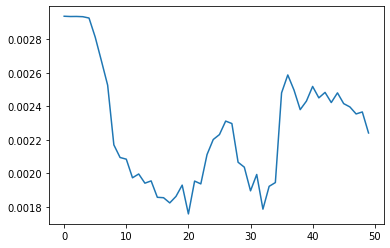

In [6]:
# fit our gating network to the data we generated above

hist = fit_model(gate_fn,X,Y,50)
plt.plot(hist)

In [ ]:
# evauluate how well our classifier is doing now

env = gym.make('su_cartpole-v0')
num_points = int(2e4)

pred_Y = torch.zeros(num_points,1)
pred_X = np.zeros((num_points,1))
up_wrong = 0; up_right = 0; down_wrong = 0; down_right = 0;
for i in trange(num_points):
        
        point = env.observation_space.sample()
        y = gate_fn(torch.as_tensor(point,dtype=torch.float64))
        
        if (point[0] > 145 * pi / 180) and (point[0] < 215 * pi / 180):
            if y < .5:
                #print("wrong!" , c)
                up_wrong +=1
            else:
                up_right +=1
        else:
            if y > .5:
                #print("wrong again!" , c)
                down_wrong +=1
            else:
                down_right +=1
       
print("balancing controller misclassified: " , up_wrong)
print("balancing controller corectly classified: " , up_right)
print("balancing controller accuracy: " , up_right/(up_right+up_wrong))

     
print("swingup controller misclassified: " , down_wrong)
print("swingup controller corectly classified: " , down_right)
print("balancing controller accuracy: " , down_right/(down_right+down_wrong))

In [ ]:
t_policy, t_val, rewards, var_dict = ppo('su_cartpole_push-v0', 500, policy, value_fn, action_var = .1)
#t_policy, t_val, t_gate, rewards, var_dict = ppo_switch(
#    "su_cartpole_push-v0", 500, policy, value_fn, gate_fn, epoch_batch_size=50, reward_stop=1400
#)

plt.plot(rewards)

 99%|█████████▉| 494/500 [44:13<00:24,  4.12s/it]

In [ ]:
save_path = "./data/push_baselines/push_baseline1"
#model, env = load_model(save_path) # This is loading the trained model for analysis
t_data = pd.read_csv(save_path + '/progress.csv' ) # This is data about the training

In [ ]:
plt.plot(var_dict['action_list'])

In [ ]:
plt.plot(var_dict['path_list'])

In [ ]:
plt.plot(np.array(var_dict['state_tensor'])[:,2])
np.array(var_dict['state_tensor'])

In [ ]:
var_dict['action_tensor']